In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict, Features, ClassLabel, Value, Sequence

## Load the dataset

In [3]:
# Load the dataset from the .jsonl file
project_root = str(Path().cwd().resolve().parent)
raw_data_dir = os.path.join(project_root, "data", "raw")
dataset_path = os.path.join(raw_data_dir, "hasd.jsonl")
try:
    with open(dataset_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    print(f"✅ Dataset loaded successfully.")
    print(f"Total examples: {len(df)}")
except FileNotFoundError:
    print(f"❌ Error: The file '{dataset_path}' was not found. Please create it first.")

✅ Dataset loaded successfully.
Total examples: 2922


## Exploratory Data Analysis (EDA) and Statistics


--- 📊 Intent Distribution ---
intent
reschedule        554
cancel            548
query_avail       536
schedule          534
oos               150
negative_reply    150
greeting          150
positive_reply    150
bye               150
Name: count, dtype: int64


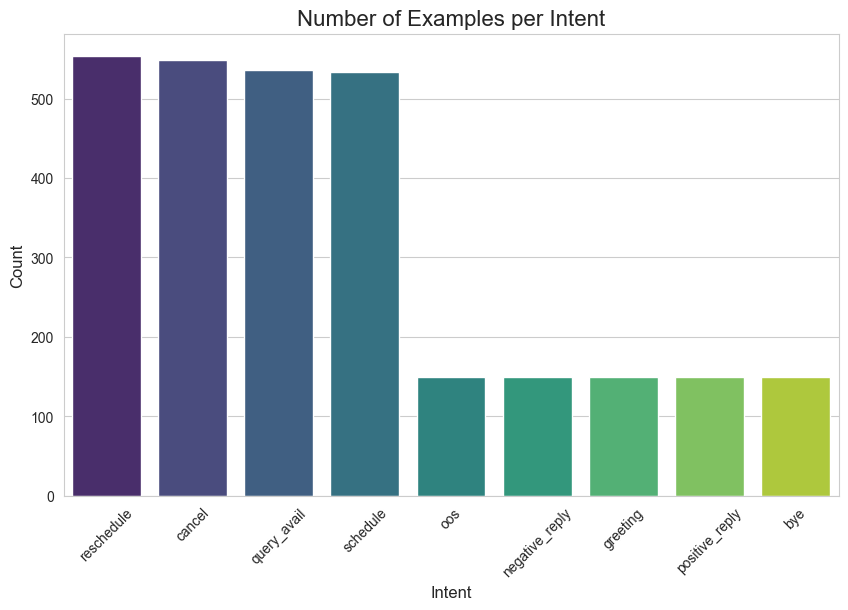


--- 🧬 Entity Analysis ---
Total examples with at least one entity: 1583
Total examples with no entities: 1339

Distribution of Entity Types:
              Entity  Count
1  practitioner_name    983
0   appointment_type    790
2     appointment_id    410


In [4]:
# Let's analyze the dataset's composition before splitting.
# Set plot style
sns.set_style("whitegrid")

# --- Intent Distribution ---
print("\n--- 📊 Intent Distribution ---")
intent_counts = df['intent'].value_counts()
print(intent_counts)

# Plotting intent distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values, hue=intent_counts.index, palette="viridis", legend=False)
plt.title("Number of Examples per Intent", fontsize=16)
plt.xlabel("Intent", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


# --- Entity Analysis ---
print("\n--- 🧬 Entity Analysis ---")

# Add a column for the number of entities in each example
df['num_entities'] = df['entities'].apply(len)
print(f"Total examples with at least one entity: {len(df[df['num_entities'] > 0])}")
print(f"Total examples with no entities: {len(df[df['num_entities'] == 0])}")

# Count the occurrences of each entity type
entity_label_counts = {}
for entities_list in df['entities']:
    for entity in entities_list:
        label = entity['label']
        entity_label_counts[label] = entity_label_counts.get(label, 0) + 1

print("\nDistribution of Entity Types:")
entity_df = pd.DataFrame(list(entity_label_counts.items()), columns=['Entity', 'Count']).sort_values('Count', ascending=False)
print(entity_df)

## Data Split

In [5]:
#Split Data into Train, Validation, and Test Sets (70/15/15)
# We will perform a stratified split to ensure each set has a similar intent distribution.

# First, split into train (70%) and a temporary set (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df['intent'] # Stratify to maintain intent proportions
)

# Second, split the temporary set (30%) into validation (15%) and test (15%)
# This means we split the temp_df in half (0.5).
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['intent'] # Also stratify this split
)

print("\n--- Data Split Summary ---")
print(f"Training set size:   {len(train_df)} ({len(train_df)/len(df):.0%})")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df):.0%})")
print(f"Test set size:       {len(test_df)} ({len(test_df)/len(df):.0%})")


--- Data Split Summary ---
Training set size:   2045 (70%)
Validation set size: 438 (15%)
Test set size:       439 (15%)


## Save Splits

In [6]:
# Save the three new DataFrames to the data/raw directory.

# Define file paths
train_path = os.path.join(raw_data_dir, "train.jsonl")
val_path = os.path.join(raw_data_dir, "validation.jsonl")
test_path = os.path.join(raw_data_dir, "test.jsonl")

# Save using pandas' built-in JSONL export
# Note: We drop the 'num_entities' helper column we used for statistics before saving
train_df.drop(columns=['num_entities']).to_json(train_path, orient='records', lines=True, force_ascii=False)
val_df.drop(columns=['num_entities']).to_json(val_path, orient='records', lines=True, force_ascii=False)
test_df.drop(columns=['num_entities']).to_json(test_path, orient='records', lines=True, force_ascii=False)

print(f"\n✅ Data splits saved successfully.")


✅ Data splits saved successfully.


## Push to Hugging Face Hub

In [7]:
data_files = {
    "train": os.path.join(raw_data_dir, "train.jsonl"),
    "validation": os.path.join(raw_data_dir, "validation.jsonl"),
    "test": os.path.join(raw_data_dir, "test.jsonl")
}
hasd = load_dataset("json", data_files=data_files)

print(hasd)
print("\nExample from training set:")
print(hasd['train'].features)
print(hasd['train'][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 2045
    })
    validation: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 438
    })
    test: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 439
    })
})

Example from training set:
{'text': Value('string'), 'intent': Value('string'), 'entities': List({'start': Value('int64'), 'end': Value('int64'), 'label': Value('string')})}
{'text': 'what is albert einstein famous for', 'intent': 'oos', 'entities': []}


In [8]:
# Get the unique intent labels from the original DataFrame `df`.
intent_names = sorted(df['intent'].unique())

# Cast the 'intent' column.
final_dataset = hasd.cast_column('intent', ClassLabel(names=intent_names))


# --- Verification ---
print("--- ✅ Final Public Dataset Schema ---")
print(final_dataset)
print("\n--- Example from the processed training set ---")
print(final_dataset['train'].features)
print(final_dataset['train'][0])

Casting the dataset:   0%|          | 0/2045 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/438 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/439 [00:00<?, ? examples/s]

--- ✅ Final Public Dataset Schema ---
DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 2045
    })
    validation: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 438
    })
    test: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 439
    })
})

--- Example from the processed training set ---
{'text': Value('string'), 'intent': ClassLabel(names=['bye', 'cancel', 'greeting', 'negative_reply', 'oos', 'positive_reply', 'query_avail', 'reschedule', 'schedule']), 'entities': List({'start': Value('int64'), 'end': Value('int64'), 'label': Value('string')})}
{'text': 'what is albert einstein famous for', 'intent': 4, 'entities': []}


In [ ]:
# Setup and Login
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

In [ ]:
hub_ds_id = os.getenv("HUB_DS_ID")
final_dataset.push_to_hub(hub_ds_id)